# Planeador

Se trata de un caso simple para comenzar a utilizar la técnica propuesta por Sindy en el ámbito de la mecánica de vuelo.

Las **ecuaciones dinámicas** son las siguientes:
$$
D = -mg\sin{\gamma} \\
L = mg\cos{\gamma}
$$
Las **ecuaciones cinemáticas** son las siguientes:
$$
\dot{x_e} =  V\cos{\gamma} \\
\dot{h} =  V\sin{\gamma}
$$

Este será el único caso en el que se tratará de obtener las ecuaciones cinemáticas y no las dinámicas. La suposición que se realiza es que el ángulo de asiento de la velocidad es constante

In [1]:
import numpy as np
import pysindy as ps
from scipy.integrate import odeint, solve_ivp

import matplotlib.pyplot as plt
from math import pi

In [2]:
n = 10000
deltat = 0.1
t = np.zeros(n+1)
for i in range(1, n+1):
    t[i] = deltat*i

print(t.shape[0], t)

10001 [0.000e+00 1.000e-01 2.000e-01 ... 9.998e+02 9.999e+02 1.000e+03]


In [3]:
#creo la matriz de datos del planeador
#el angulo de cabeceo debe ir en grados y es gamma no gammae
def create_glider_data(t, gamma0, x0, h0, v0):
    #caalculo el valor de cada variable y almaceno en un array
    n = t.shape[0]
    deltat = t[1]-t[0]

    v = v0*np.ones(n)
    gamma = -np.pi*gamma0/180*np.ones(n) #esto es gamma no gammae 

    x = np.zeros(n)
    h = np.zeros(n)
    h[0] = h0
    x[0] = x0
    for i in range(1, n):
        x[i] = x[i-1] + v[i]*np.cos(gamma[i])*deltat
        h[i] = h[i-1] + v[i]*np.sin(gamma[i])*deltat
    
    #calculo el valor de las derivadas:
    x_dot = v*np.cos(gamma)
    h_dot = v*np.sin(gamma)
    v_dot = np.zeros(n)
    gamma_dot = np.zeros(n)
    
    return np.stack((gamma, x, h, v)), np.stack((gamma_dot, x_dot, h_dot, v_dot))

In [4]:
#condiciones iniciales generadas para cada trayectoria:

n_trayec = 10
gamma0 = np.ones(n_trayec)
x0 = np.ones(n_trayec)
h0 = np.ones(n_trayec)
v0 = np.ones(n_trayec)

for i in range(n_trayec):
    gamma0[i] = np.random.uniform(low=1, high=90)
    x0[i] =  np.random.uniform(low=0, high=100)
    h0[i] =  np.random.uniform(low=100, high=1000)
    v0[i] =  np.random.uniform(low=1, high=10)

In [5]:
# creo cada trayectoria llamandado a create_glider_data
#las trayectorias son filas mientras que las columnas son caracterisitcas
data1 = []
ders1 = []
for i in range(n_trayec):
    p, h = create_glider_data(t, gamma0[i], x0[i], h0[i], v0[i])
    data1.append(p.T)
    ders1.append(h.T)

In [6]:
# adimensionalizo por el valor maximo de cada caracteristica para todas las trayectorias
maxi = np.max(data1, axis=1)
maxi = np.max(maxi, axis=0)
data1_adim = []
for i in range(n_trayec):
    data1_adim.append(data1[i] / maxi)
#print(len(data1_adim), data1_adim[0].shape)

Text(0.5, 0, 'Tiempo')

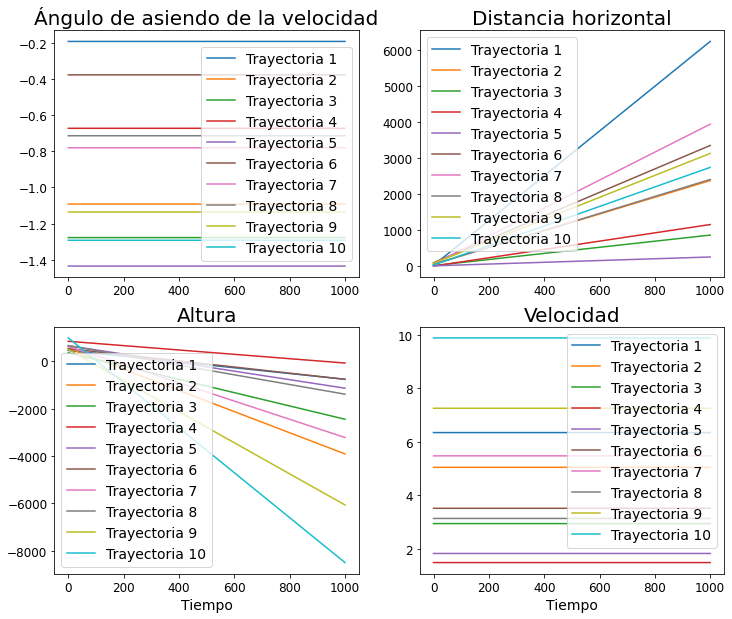

In [7]:
f, ax = plt.subplots(2,2,figsize=(12,10))

labels = ['Ángulo de asiendo de la velocidad', 'Distancia horizontal', 'Altura', 'Velocidad']

for i, a in enumerate(ax.ravel()):
    for j in range(n_trayec):
        a.plot(t, data1[j][:,i], label='Trayectoria '+ str(j+1))
    
    a.set_title(labels[i], fontsize=20)

    a.tick_params(axis='both', which='major', labelsize=12)
    a.legend(fontsize=14)

ax[1,0].set_xlabel("Tiempo", fontsize=14)
ax[1,1].set_xlabel("Tiempo", fontsize=14)

In [8]:
def custom_library2():
    library_functions = [
        lambda theta, d : d*np.sin(theta),
        lambda theta, d : d*np.cos(theta),
        #lambda d: 0,
    ]
    library_function_names = [
        lambda theta, d : '+' + d + '*' + 'sen(' + theta + ')',
        lambda theta, d : d + '*' + 'cos(' + theta + ')', 
        #lambda d: d
    ]
    library = ps.CustomLibrary(library_functions=library_functions, function_names=library_function_names,
                              interaction_only=True)
    return library

In [9]:
# creo un initial guess para que la primera solucion que encuentre no sea la de todas las ecuaciones = 0
lib = custom_library2().fit(data1[0])
n_features = lib.n_output_features_
initial_guess = np.ones((data1[0].shape[1], n_features))

print(data1[0].shape[1], n_features)
print(lib.get_feature_names(['gamma', 'x', 'h', 'v']))

4 12
['+x*sen(gamma)', '+h*sen(gamma)', '+v*sen(gamma)', '+h*sen(x)', '+v*sen(x)', '+v*sen(h)', 'x*cos(gamma)', 'h*cos(gamma)', 'v*cos(gamma)', 'h*cos(x)', 'v*cos(x)', 'v*cos(h)']


In [10]:
model = ps.SINDy(
        #differentiation_method=ps.SINDyDerivative(kind='finite_difference', k=1),
        optimizer=ps.SR3(initial_guess=None),
        feature_library=custom_library2(),
        ##ps.PolynomialLibrary(degree=2)#interaction_only=terminos_ctes,
                                                         
        feature_names=None#['gamma', 'x', 'h', 'v'], #'x', 'y', 'v', 'alfa', 'theta', "theta'"
    )

#la doc dice que en t hay que poner el time step
model.fit(data1, t=deltat, multiple_trajectories=True) #

#print(model.equations(precision=52))
model.print(precision=4)

x0' = 0.0000
x1' = 1.0000 x3*cos(x0)
x2' = 1.0000 +x3*sen(x0)
x3' = 0.0000


Text(0.5, 0, 'Tiempo')

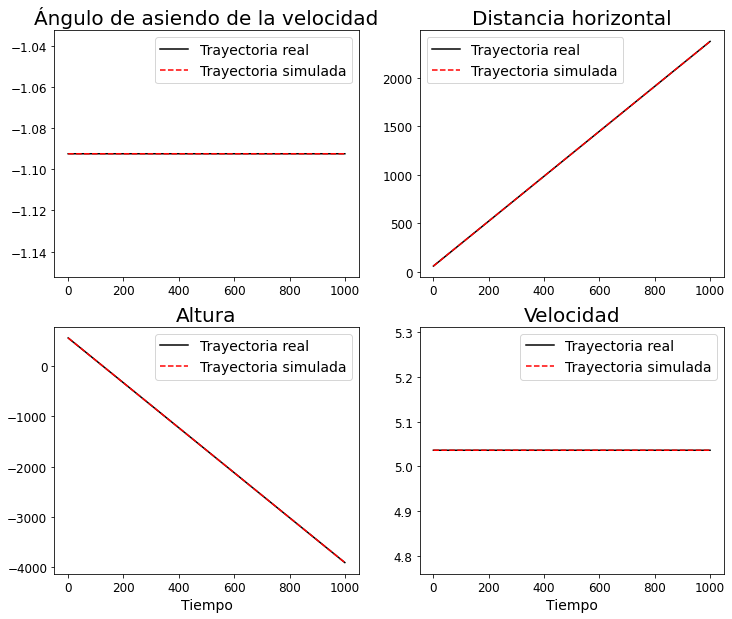

In [11]:
f, ax = plt.subplots(2,2,figsize=(12,10))

labels = ['Ángulo de asiendo de la velocidad', 'Distancia horizontal', 'Altura', 'Velocidad']
# compruebo lo resultados para una condicion inicial que ya "ha visto"
x_sim = model.simulate(data1[1][0], t)

for i, a in enumerate(ax.ravel()):
    
    a.plot(t, data1[1][:,i], 'k', label='Trayectoria real')
    a.plot(t, x_sim[:, i], 'r--', label='Trayectoria simulada')
    
    a.set_title(labels[i], fontsize=20)

    a.tick_params(axis='both', which='major', labelsize=12)
    a.legend(fontsize=14)

ax[1,0].set_xlabel("Tiempo", fontsize=14)
ax[1,1].set_xlabel("Tiempo", fontsize=14)

Text(0.5, 0, 'Tiempo')

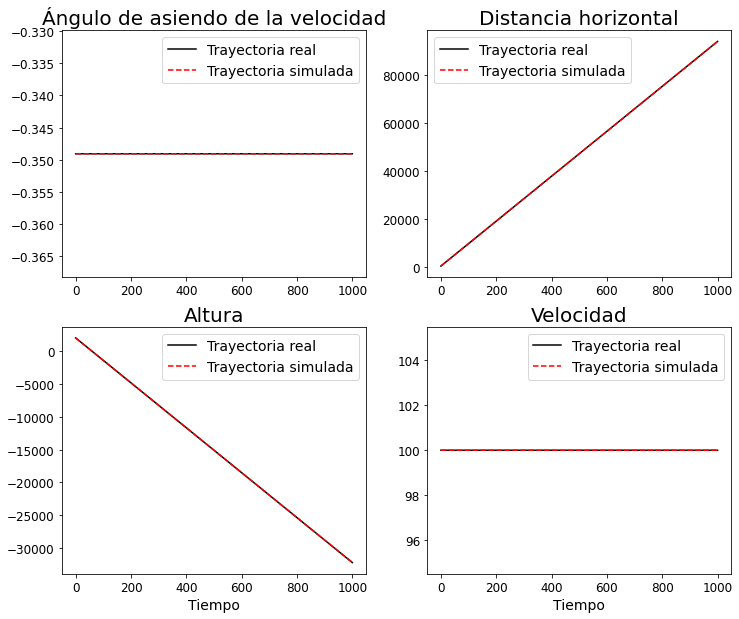

In [17]:
f, ax = plt.subplots(2,2,figsize=(12,10))

labels = ['Ángulo de asiendo de la velocidad', 'Distancia horizontal', 'Altura', 'Velocidad']
# compruebo lo resultados para una condicion inicial que aun no ha visto el algoritmo
data_val = []
data_val, _ = create_glider_data(t, 20, 200, 2000, 100) # gamma, x, h, v,
data_val = data_val.T

x_sim = model.simulate(data_val[0], t)

for i, a in enumerate(ax.ravel()):
    
    a.plot(t, data_val[:,i], 'k', label='Trayectoria real')
    a.plot(t, x_sim[:, i], 'r--', label='Trayectoria simulada')
    
    a.set_title(labels[i], fontsize=20)

    a.tick_params(axis='both', which='major', labelsize=12)
    a.legend(fontsize=14)

ax[1,0].set_xlabel("Tiempo", fontsize=14)
ax[1,1].set_xlabel("Tiempo", fontsize=14)